# Demographics Transition Model - Fitting UN & World Bank data
*Simon Lebastard, April 2023*<br><br>
Inspired by Victor Court & Florant McIsaac, "A Representation of the World Population Dynamics for Integrated Assessment Models", March 2020

In [1]:
import numpy as np
import pandas as pd
import os.path

### Loading data + preprocessing

In [2]:
datapath_un = "/Users/slebst/Documents/georgetown/ejp/ra/endogenous-population/UN_WorldPopulationProspects"
datapath_wb = "/Users/slebst/Documents/georgetown/ejp/ra/endogenous-population/WorldBank_GWP"

pop = pd.read_csv(os.path.join(datapath_un,"population-byagegroup.csv"))
births = pd.read_csv(os.path.join(datapath_un,"births-byagegroup.csv"))
deaths_raw = pd.read_csv(os.path.join(datapath_un,"deaths-byagegroup.csv"))
gwp_percapita = pd.read_csv(os.path.join(datapath_wb,"GDP_per_capita.csv"))

In [3]:
pop.set_index("Year", inplace=True)
births.set_index("Year", inplace=True)
deaths_raw.set_index("Year", inplace=True)

pop = pop.astype(int)
births = births.astype(int)
deaths_raw = deaths_raw.astype(int)

gwp_percapita.rename(columns={
    "Indicator Name": "Year", 
    "GDP per capita (constant 2015 US$)": "gwp_percapita"
    }, inplace=True)
gwp_percapita.set_index("Year", inplace=True)
gwp_percapita.drop([2020, 2021], axis=0, inplace=True)

In [4]:
age_groups = list(pop.columns)
fertile_age_groups = list(births.columns)

In [5]:
deaths_raw.columns

Index(['0', '0-4', '0-14', '0-19', '0-24', '1-4', '5-14', '15+', '15-24',
       '15-49', '15-59', '15-64', '20+', '20-64', '20-69', '25+', '25-69',
       '40+', '50+', '60+', '65+', '70+', '80+', '90+', '100+'],
      dtype='object')

In [6]:
# As we don't have all the age groups for mortality, I will do some coarse interpolation
deaths_raw["5-9"] = 0.5*(deaths_raw["0-14"] - deaths_raw["0-4"])
deaths_raw["10-14"] = deaths_raw["5-9"]

deaths_raw["15-19"] = deaths_raw["0-19"] - deaths_raw["0-14"]
deaths_raw["20-24"] = deaths_raw["20+"] - deaths_raw["25+"]

deaths_raw["25-29"] = (deaths_raw["25+"] - deaths_raw["40+"])/3
deaths_raw["30-34"] = deaths_raw["25-29"]
deaths_raw["35-39"] = deaths_raw["25-29"]

deaths_raw["40-44"] = (deaths_raw["40+"] - deaths_raw["50+"])/2
deaths_raw["45-49"] = deaths_raw["40-44"]

deaths_raw["50-54"] = (deaths_raw["50+"] - deaths_raw["60+"])/2
deaths_raw["55-59"] = deaths_raw["50-54"]

deaths_raw["60-64"] = deaths_raw["60+"] - deaths_raw["65+"]
deaths_raw["65-69"] = deaths_raw["65+"] - deaths_raw["70+"]

deaths_raw["70-74"] = (deaths_raw["70+"] - deaths_raw["80+"])/2
deaths_raw["75-79"] = deaths_raw["70-74"]

deaths_raw["80-84"] = (deaths_raw["80+"] - deaths_raw["90+"])/2
deaths_raw["85-89"] = deaths_raw["80-84"]

deaths_raw["90-94"] = (deaths_raw["90+"] - deaths_raw["100+"])/2
deaths_raw["95-99"] = deaths_raw["90-94"]

In [7]:
idx = pd.IndexSlice
deaths = deaths_raw.loc[:,idx[pop.columns]]

Preping for 1d model:

In [8]:
births["total"] = births.iloc[:,:-1].sum(axis=1)
deaths["total"] = deaths.iloc[:,:-1].sum(axis=1)
pop["total"] = pop.iloc[:,:-1].sum(axis=1)

In [9]:
births.columns

Index(['10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', 'total'],
      dtype='object')

In [10]:
deaths.columns

Index(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
       '80-84', '85-89', '90-94', '95-99', '100+', '65+', 'total'],
      dtype='object')

In [11]:
age_groups_dct = {col_id: col_name for col_id,col_name in enumerate(list(pop.columns))}

Preping for 4d model:

In [12]:
age_groups_3dmap = [
    [0, 1],
    [2, 3, 4, 5, 6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    ]

age_groups_4dmap = [
    [0, 1],
    [2, 3, 4, 5, 6, 7, 8, 9, 10],
    [11, 12],
    [13, 14, 15, 16, 17, 18, 19, 20]
    ]

court_age_groups = list(range(13)) + [21]
fertile_court_age_groups = [3, 4, 5, 6, 7, 8, 9]

In [13]:
pop["4D-G1"] = pop.iloc[:,age_groups_4dmap[0]].sum(axis=1)
pop["4D-G2"] = pop.iloc[:,age_groups_4dmap[1]].sum(axis=1)
pop["4D-G3"] = pop.iloc[:,age_groups_4dmap[2]].sum(axis=1)
pop["4D-G4"] = pop.iloc[:,age_groups_4dmap[3]].sum(axis=1)

births["4D-G1"] = 0
births["4D-G2"] = births.iloc[:,:-1].sum(axis=1)
births["4D-G3"] = 0
births["4D-G4"] = 0

for group_id in set(court_age_groups).difference(set(fertile_court_age_groups)):
    births[age_groups_dct[group_id]] = 0

deaths["4D-G1"] = deaths.iloc[:,age_groups_4dmap[0]].sum(axis=1)
deaths["4D-G2"] = deaths.iloc[:,age_groups_4dmap[1]].sum(axis=1)
deaths["4D-G3"] = deaths.iloc[:,age_groups_4dmap[2]].sum(axis=1)
deaths["4D-G4"] = deaths.iloc[:,age_groups_4dmap[3]].sum(axis=1)

Merging dataframes:

In [14]:
df = pd.merge(
    left = gwp_percapita,
    right = pop,
    on = "Year",
    how = "left"
    ).merge(
    deaths,
    on = "Year",
    how = "left",
    suffixes = ["_POP", "_D"]
    ).merge(
    births.rename(columns={col: col+"_B" for col in list(births.columns)}),
    on = "Year",
    how = "left"
    )

In [15]:
df.columns

Index(['gwp_percapita', '0-4_POP', '5-9_POP', '10-14_POP', '15-19_POP',
       '20-24_POP', '25-29_POP', '30-34_POP', '35-39_POP', '40-44_POP',
       '45-49_POP', '50-54_POP', '55-59_POP', '60-64_POP', '65-69_POP',
       '70-74_POP', '75-79_POP', '80-84_POP', '85-89_POP', '90-94_POP',
       '95-99_POP', '100+_POP', '65+_POP', 'total_POP', '4D-G1_POP',
       '4D-G2_POP', '4D-G3_POP', '4D-G4_POP', '0-4_D', '5-9_D', '10-14_D',
       '15-19_D', '20-24_D', '25-29_D', '30-34_D', '35-39_D', '40-44_D',
       '45-49_D', '50-54_D', '55-59_D', '60-64_D', '65-69_D', '70-74_D',
       '75-79_D', '80-84_D', '85-89_D', '90-94_D', '95-99_D', '100+_D',
       '65+_D', 'total_D', '4D-G1_D', '4D-G2_D', '4D-G3_D', '4D-G4_D',
       '10-14_B', '15-19_B', '20-24_B', '25-29_B', '30-34_B', '35-39_B',
       '40-44_B', '45-49_B', '50-54_B', 'total_B', '4D-G1_B', '4D-G2_B',
       '4D-G3_B', '4D-G4_B', '0-4_B', '5-9_B', '55-59_B', '60-64_B', '65+_B'],
      dtype='object')

Computing birth and death rates:

In [16]:
for group_id, group in enumerate(age_groups):
    if group_id<2:
        df["BR_{0:s}".format(group)] = 0
    elif group_id>10:
        df["BR_{0:s}".format(group)] = 0
    else:
        df["BR_{0:s}".format(group)] = df["{0:s}_B".format(group)]/df["{0:s}_POP".format(group)]
    df["DR_{0:s}".format(group)] = df["{0:s}_D".format(group)]/df["{0:s}_POP".format(group)]

for group4d_id in range(1,5):
    df["BR_4D-G{0:d}".format(group4d_id)] = df["4D-G{0:d}_B".format(group4d_id)] / df["4D-G{0:d}_POP".format(group4d_id)]
    df["DR_4D-G{0:d}".format(group4d_id)] = df["4D-G{0:d}_D".format(group4d_id)] / df["4D-G{0:d}_POP".format(group4d_id)]

df["BR_1D"] = df["total_B"] / df["total_POP"]
df["DR_1D"] = df["total_D"] / df["total_POP"]

# Demographic transition model fitting

In [19]:
from scipy.optimize import curve_fit

def demo_transition(y, lvl_min, ampl, y_crit, std):
    """
    Implements the Court-McIsaac model of demographics transition.
    BR can be either a birth rate or a death rate,
    potentially specific to an age-group
    """
    return lvl_min + ampl/(1 + np.exp(std*(y-y_crit)))

In [20]:
from matplotlib import pyplot as plt

### 4D population model

Throughout, we will use the 4d model as the reference, as it is a great compromise on dimensionality and variance (discrimination of BR and DR with age)

**POPULATION**

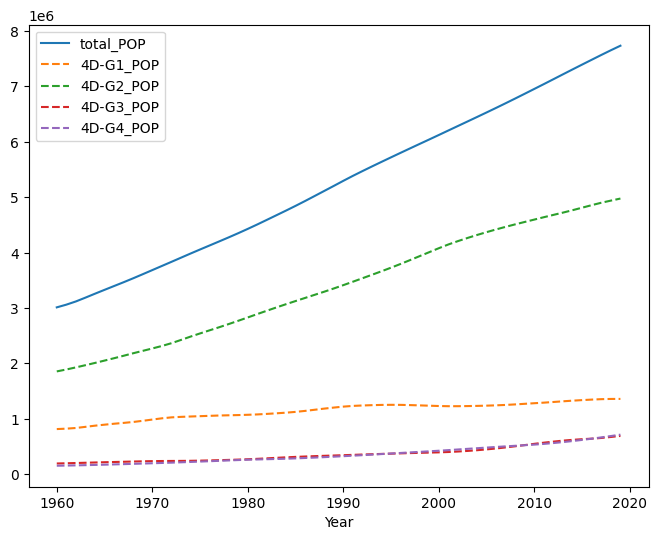

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

df.plot(y="total_POP", use_index=True, ax=ax)

for group_id in range(1,5):
    df.plot(y="4D-G{0:d}_POP".format(group_id), use_index=True, ax=ax, color="C{0:d}".format(group_id), linestyle='--')


**BIRTH RATE** Only the second group is fertile:

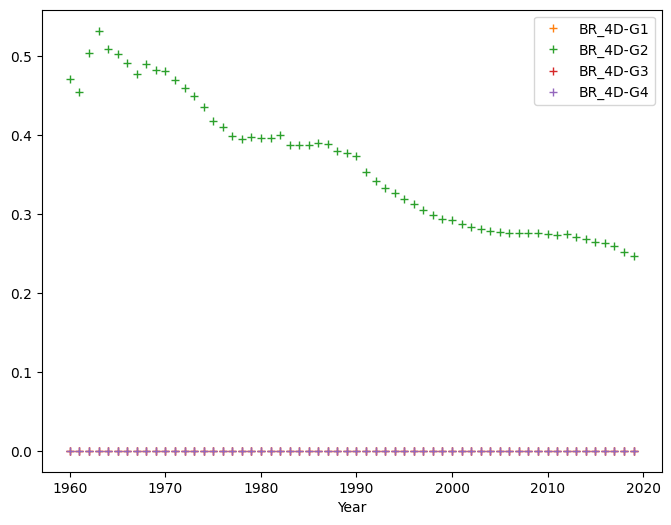

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for group_id in range(1,5):
    df.plot(y="BR_4D-G{0:d}".format(group_id), use_index=True, ax=ax, color="C{0:d}".format(group_id), marker='+', linestyle='')

**DEATH RATES**

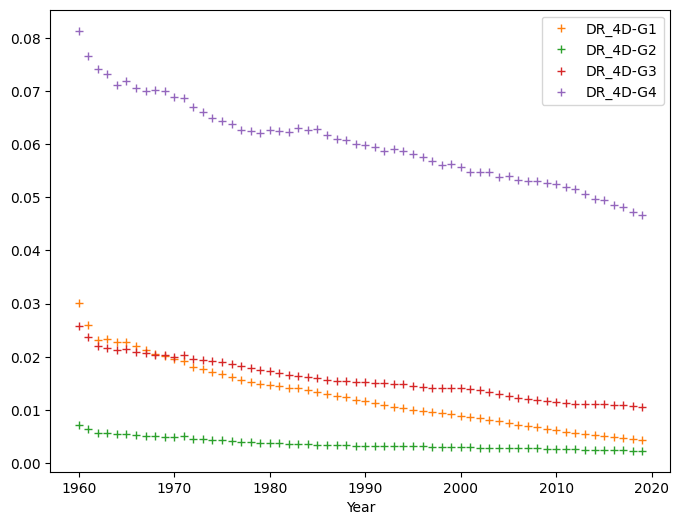

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for group_id in range(1,5):
    df.plot(y="DR_4D-G{0:d}".format(group_id), use_index=True, ax=ax, color="C{0:d}".format(group_id), marker='+', linestyle='')

### Graphing demographics vs GWP-per-capita

**BIRTH RATE**

<Axes: xlabel='gwp_percapita'>

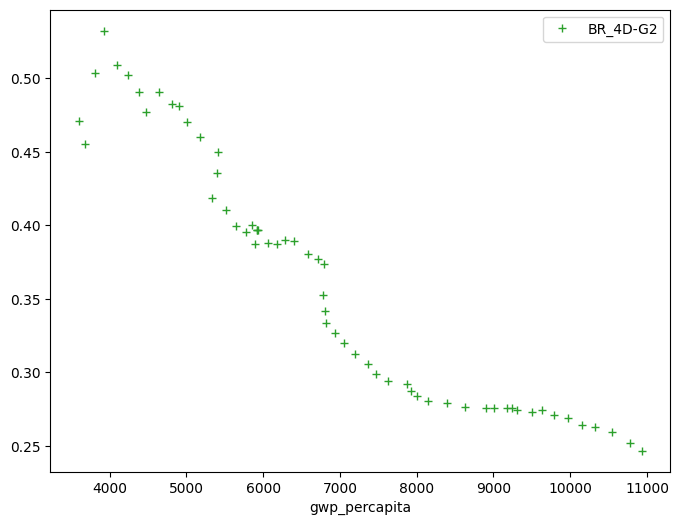

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

df.plot(
    x="gwp_percapita",
    y="BR_4D-G2",
    ax=ax,
    marker='+',
    linestyle='',
    color="C2"
)

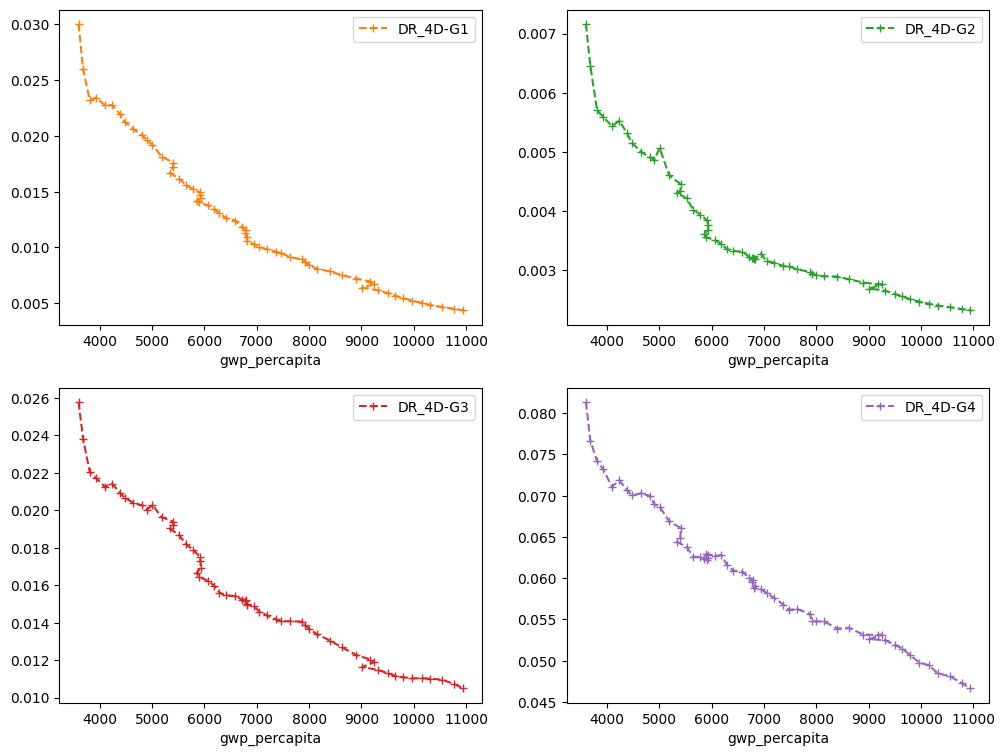

In [23]:
fig_DR, ax_DR = plt.subplots(2,2, figsize=(12,9))

for group4d_id in range(1,5):
    df.plot(
        x="gwp_percapita",
        y="DR_4D-G{0:d}".format(group4d_id),
        ax=ax_DR[(group4d_id-1)//2,(group4d_id-1)%2],
        color="C{0:d}".format(group4d_id),
        marker='+',
        linestyle='--'
    )

    ax_DR[(group4d_id-1)//2,(group4d_id-1)%2].legend()

## Fitting 4d model

In [24]:
DR4D_popts = {}
DR4D_pcovs = {}

#demo_transition(y, lvl_min, ampl, y_crit, std):
# Building initial guesses
p0 = {
    "BR_4D-G2": [
    np.min(df["BR_4D-G2"].to_numpy()),
    np.max(df["BR_4D-G2"].to_numpy()) - np.min(df["BR_4D-G2"].to_numpy()),
    np.median(df.gwp_percapita.to_numpy()),
    np.log(3)/(0.15*np.median(df.gwp_percapita.to_numpy()))] for group4d_id in range(1,5) # last condition is a moment matching on the 3rd quartile of the sigmoid
}
p0.update({
    "DR_4D-G{0:d}".format(group4d_id): [
    0.9*np.min(df["DR_4D-G{0:d}".format(group4d_id)].to_numpy()),
    2*(np.max(df["DR_4D-G{0:d}".format(group4d_id)].to_numpy()) - 0.9*np.min(df["DR_4D-G{0:d}".format(group4d_id)].to_numpy())),
    np.min(df.gwp_percapita.to_numpy()),
    np.log(3)/(0.6*np.min(df.gwp_percapita.to_numpy()))] for group4d_id in range(1,4)
})
p0.update({
    "DR_4D-G4": [
    0.045,
    0.09,
    2500,
    np.log(3)/(0.9*2800)] for group4d_id in range(1,4)
})

BR4D_popt, BR4D_pcov = curve_fit(demo_transition, df.gwp_percapita.to_numpy(), df["BR_4D-G2"].to_numpy(), p0["BR_4D-G2"], method='dogbox')

for group4d_id in range(1,4):
    DR4D_popt, DR4D_pcov = curve_fit(demo_transition, df.gwp_percapita.to_numpy(), df["DR_4D-G{0:d}".format(group4d_id)].to_numpy(), p0["DR_4D-G{0:d}".format(group4d_id)], method='dogbox')
    DR4D_popts["DR_4D-G{0:d}".format(group4d_id)] = DR4D_popt
    DR4D_pcovs["DR_4D-G{0:d}".format(group4d_id)] = DR4D_pcov

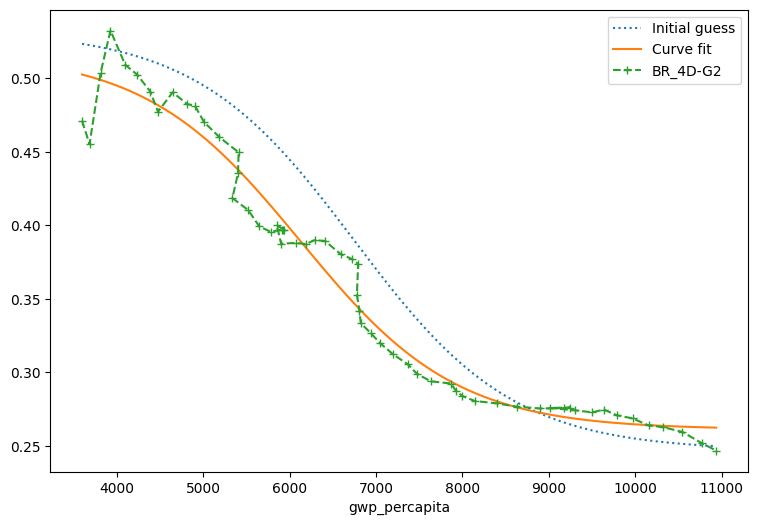

In [25]:
gdppc_min = np.min(df.gwp_percapita.to_numpy())
gdppc_max = np.max(df.gwp_percapita.to_numpy())

fig_BR, ax_BR = plt.subplots(1,1, figsize=(9,6))

x = np.linspace(gdppc_min, gdppc_max, 10000)
BR4D_fct_init = demo_transition(x, *p0["BR_4D-G2"])
BR4D_fct_est = demo_transition(x, *BR4D_popt)

ax_BR.plot(x, BR4D_fct_init, linestyle=':', label="Initial guess")
ax_BR.plot(x, BR4D_fct_est, linestyle='-', label="Curve fit")

df.plot(
    x="gwp_percapita",
    y="BR_4D-G2",
    ax=ax_BR,
    color="C2",
    marker='+',
    linestyle='--'
)

ax_BR.legend()

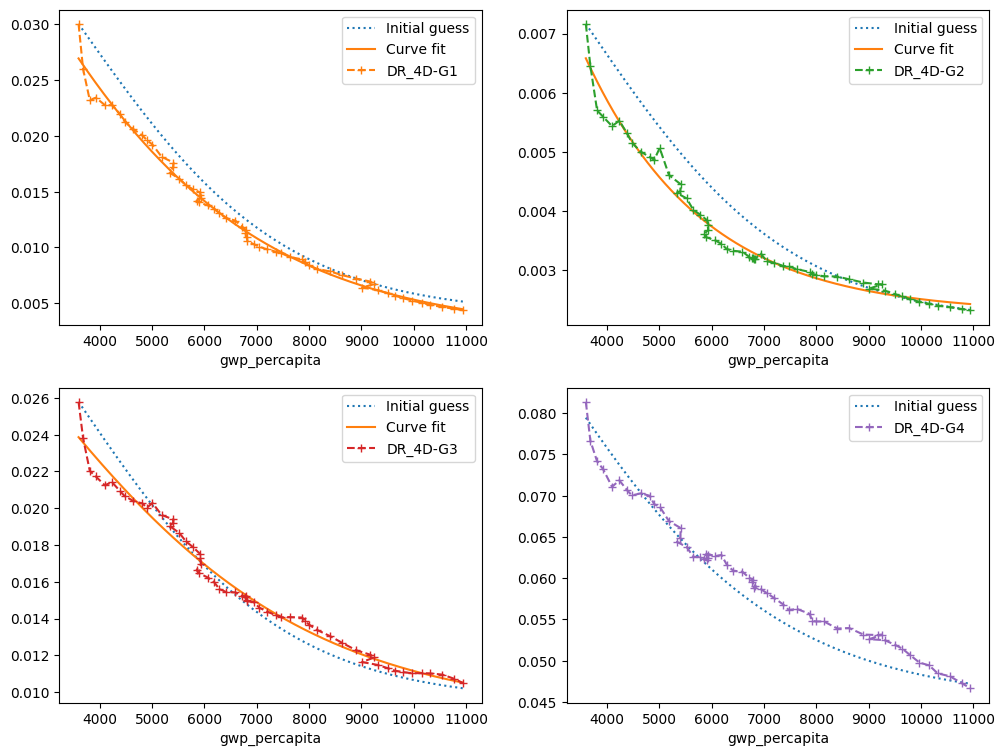

In [26]:
fig_DR, ax_DR = plt.subplots(2,2, figsize=(12,9))

DR4D_fcts = {
    "DR_4D-G{0:d}".format(group4d_id): {
        "init": demo_transition(x, *p0["DR_4D-G{0:d}".format(group4d_id)]),
        "est": demo_transition(x, *DR4D_popts["DR_4D-G{0:d}".format(group4d_id)])} for group4d_id in range(1,4)
}
DR4D_fcts["DR_4D-G4"] = {"init": demo_transition(x, *p0["DR_4D-G4"])}

for group4d_id in range(1,5):
    ax_DR[(group4d_id-1)//2,(group4d_id-1)%2].plot(x, DR4D_fcts["DR_4D-G{0:d}".format(group4d_id)]["init"], linestyle=':', label="Initial guess")
    if group4d_id<4:
        ax_DR[(group4d_id-1)//2,(group4d_id-1)%2].plot(x, DR4D_fcts["DR_4D-G{0:d}".format(group4d_id)]["est"], linestyle='-', label="Curve fit")

    df.plot(
        x="gwp_percapita",
        y="DR_4D-G{0:d}".format(group4d_id),
        ax=ax_DR[(group4d_id-1)//2,(group4d_id-1)%2],
        color="C{0:d}".format(group4d_id),
        marker='+',
        linestyle='--'
    )

    ax_DR[(group4d_id-1)//2,(group4d_id-1)%2].legend()

Exporting 4D model parameters to a dictionnary for chimes:

In [27]:
print("""
4D model - Birth rate parameters for fertile group (G2)
----------------------
BR_min={BR_min:.2e} <------ BR_low
ampl={ampl:.2e}
==> BR_max={BR_max:.2e} <-- BR_high
y_crit={y_crit:.2e}
std={std:.2e}
""".format(
    BR_min = BR4D_popt[0],
    ampl = BR4D_popt[1],
    BR_max = BR4D_popt[0]+BR4D_popt[1],
    y_crit = BR4D_popt[2],
    std = BR4D_popt[3]
))


4D model - Birth rate parameters for fertile group (G2)
----------------------
BR_min=2.61e-01 <------ BR_low
ampl=2.56e-01
==> BR_max=5.17e-01 <-- BR_high
y_crit=6.13e+03
std=1.11e-03



In [28]:
print("""
4D model - Death rates parameters
=================================
Group 1 - 0-14yo
-----------------
DR_min={DR1_min:.2e}
ampl={ampl1:.2e}
DR_max={DR1_max:.2e}
y_crit={y_crit1:.2e}
std={std1:.2e}

=================================
Group 2 - 15-54yo
-----------------
DR_min={DR2_min:.2e}
ampl={ampl2:.2e}
DR_max={DR2_max:.2e}
y_crit={y_crit2:.2e}
std={std2:.2e}

=================================
Group 3 - 55-64yo
-----------------
DR_min={DR3_min:.2e}
ampl={ampl3:.2e}
DR_max={DR3_max:.2e}
y_crit={y_crit3:.2e}
std={std3:.2e}

=================================
Group 4 - 65+yo
-----------------
DR_min={DR4_min:.2e}
ampl={ampl4:.2e}
DR_max={DR4_max:.2e}
y_crit={y_crit4:.2e}
std={std4:.2e}
""".format(
    DR1_min = DR4D_popts["DR_4D-G1"][0],
    ampl1 = DR4D_popts["DR_4D-G1"][1],
    DR1_max = DR4D_popts["DR_4D-G1"][0] + DR4D_popts["DR_4D-G1"][0],
    y_crit1 = DR4D_popts["DR_4D-G1"][2],
    std1 = DR4D_popts["DR_4D-G1"][3],
    DR2_min = DR4D_popts["DR_4D-G2"][0],
    ampl2 = DR4D_popts["DR_4D-G2"][1],
    DR2_max = DR4D_popts["DR_4D-G2"][0] + DR4D_popts["DR_4D-G2"][0],
    y_crit2 = DR4D_popts["DR_4D-G2"][2],
    std2 = DR4D_popts["DR_4D-G2"][3],
    DR3_min = DR4D_popts["DR_4D-G3"][0],
    ampl3 = DR4D_popts["DR_4D-G3"][1],
    DR3_max = DR4D_popts["DR_4D-G3"][0] + DR4D_popts["DR_4D-G3"][0],
    y_crit3 = DR4D_popts["DR_4D-G3"][2],
    std3 = DR4D_popts["DR_4D-G3"][3],
    DR4_min = p0["DR_4D-G4"][0],
    ampl4 = p0["DR_4D-G4"][1],
    DR4_max = p0["DR_4D-G4"][0] + p0["DR_4D-G4"][0],
    y_crit4 = p0["DR_4D-G4"][2],
    std4 = p0["DR_4D-G4"][3],
))


4D model - Death rates parameters
Group 1 - 0-14yo
-----------------
DR_min=2.31e-03
ampl=1.06e-01
DR_max=4.62e-03
y_crit=3.33e+02
std=3.65e-04

Group 2 - 15-54yo
-----------------
DR_min=2.27e-03
ampl=1.36e-01
DR_max=4.53e-03
y_crit=-3.88e+03
std=4.58e-04

Group 3 - 55-64yo
-----------------
DR_min=8.78e-03
ampl=4.26e-02
DR_max=1.76e-02
y_crit=1.88e+03
std=3.49e-04

Group 4 - 65+yo
-----------------
DR_min=4.50e-02
ampl=9.00e-02
DR_max=9.00e-02
y_crit=2.50e+03
std=4.36e-04



In [30]:
print("""
params_4d = {{
    \"G1\":{{
        \"DR_low\": {DR1_low:.2e},
        \"DR_high\": {DR1_high:.2e},
        \"y_crit_DR\": {y_crit_DR1:.2e},
        \"DR_std\": {DR1_std:.2e},
    }},
    \"G2\":{{
        \"BR_low\": {BR2_low:.2e},
        \"BR_high\": {BR2_high:.2e},
        \"y_crit_BR\": {y_crit_BR2:.2e},
        \"BR_std\": {BR2_std:.2e},

        \"DR_low\": {DR2_low:.2e},
        \"DR_high\": {DR2_high:.2e},
        \"y_crit_DR\": {y_crit_DR2:.2e},
        \"DR_std\": {DR2_std:.2e},
    }},
    \"G3\":{{
        \"DR_low\": {DR3_low:.2e},
        \"DR_high\": {DR3_high:.2e},
        \"y_crit_DR\": {y_crit_DR3:.2e},
        \"DR_std\": {DR3_std:.2e},
    }},
    \"G4\":{{
        \"DR_low\": {DR4_low:.2e},
        \"DR_high\": {DR4_high:.2e},
        \"y_crit_DR\": {y_crit_DR4:.2e},
        \"DR_std\": {DR4_std:.2e},
    }},
}}
""".format(
    DR1_low = DR4D_popts["DR_4D-G1"][0],
    DR1_high = DR4D_popts["DR_4D-G1"][0]+DR4D_popts["DR_4D-G1"][1],
    y_crit_DR1 = DR4D_popts["DR_4D-G1"][2],
    DR1_std = DR4D_popts["DR_4D-G1"][3],
    BR2_low = BR4D_popt[0],
    BR2_high = BR4D_popt[0] + BR4D_popt[0],
    y_crit_BR2 = BR4D_popt[2],
    BR2_std = BR4D_popt[3],
    DR2_low = DR4D_popts["DR_4D-G2"][0],
    DR2_high = DR4D_popts["DR_4D-G2"][0] + DR4D_popts["DR_4D-G2"][0],
    y_crit_DR2 = DR4D_popts["DR_4D-G2"][2],
    DR2_std = DR4D_popts["DR_4D-G2"][3],
    DR3_low = DR4D_popts["DR_4D-G3"][0],
    DR3_high = DR4D_popts["DR_4D-G3"][0] + DR4D_popts["DR_4D-G3"][0],
    y_crit_DR3 = DR4D_popts["DR_4D-G3"][2],
    DR3_std = DR4D_popts["DR_4D-G3"][3],
    DR4_low = p0["DR_4D-G4"][0],
    DR4_high = p0["DR_4D-G4"][0] + p0["DR_4D-G4"][0],
    y_crit_DR4 = p0["DR_4D-G4"][2],
    DR4_std = p0["DR_4D-G4"][3],
))


params_4d = {
    "G1":{
        "DR_low": 2.31e-03,
        "DR_high": 1.08e-01,
        "y_crit_DR": 3.33e+02,
        "DR_std": 3.65e-04,
    },
    "G2":{
        "BR_low": 2.61e-01,
        "BR_high": 5.22e-01,
        "y_crit_BR": 6.13e+03,
        "BR_std": 1.11e-03,

        "DR_low": 2.27e-03,
        "DR_high": 4.53e-03,
        "y_crit_DR": -3.88e+03,
        "DR_std": 4.58e-04,
    },
    "G3":{
        "DR_low": 8.78e-03,
        "DR_high": 1.76e-02,
        "y_crit_DR": 1.88e+03,
        "DR_std": 3.49e-04,
    },
    "G4":{
        "DR_low": 4.50e-02,
        "DR_high": 9.00e-02,
        "y_crit_DR": 2.50e+03,
        "DR_std": 4.36e-04,
    },
}



## Fitting 14 Court-McIsaac categories model

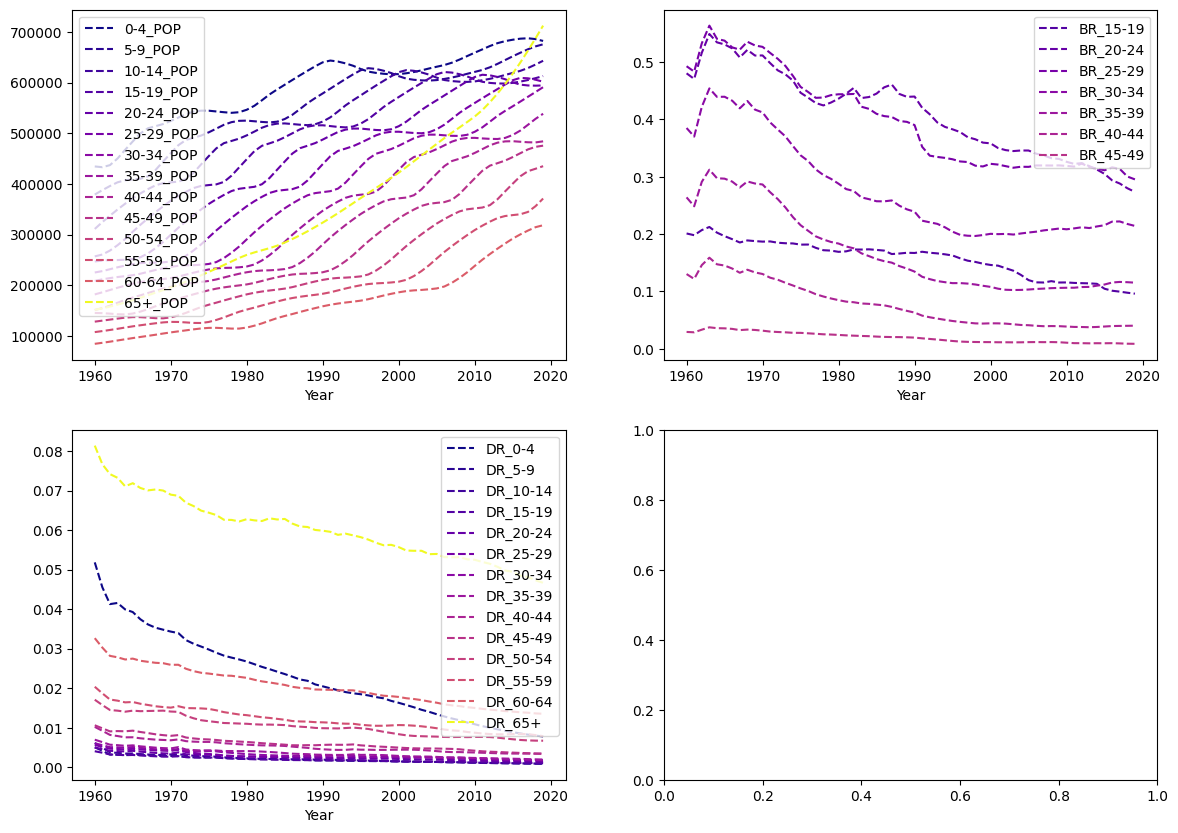

In [22]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
colors = plt.cm.plasma(np.linspace(0, 1, 22))

for group_id in court_age_groups:
    df.plot(y="{0:s}_POP".format(age_groups_dct[group_id]), use_index=True, ax=ax[0,0], color=colors[group_id], linestyle='--')
    if group_id in fertile_court_age_groups:
        df.plot(y="BR_{0:s}".format(age_groups_dct[group_id]), use_index=True, ax=ax[0,1], color=colors[group_id], linestyle='--')
    df.plot(y="DR_{0:s}".format(age_groups_dct[group_id]), use_index=True, ax=ax[1,0], color=colors[group_id], linestyle='--')

### Graphing demographics vs GWP-per-capita

**BIRTH RATE**

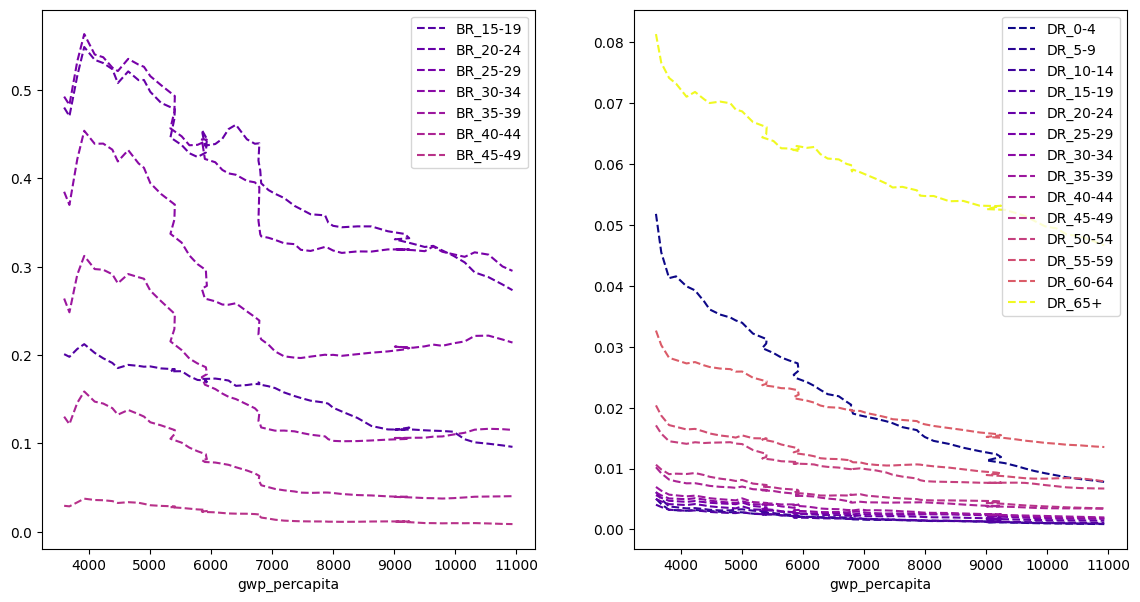

In [23]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
colors = plt.cm.plasma(np.linspace(0, 1, 22))

for group_id in court_age_groups:
    if group_id in fertile_court_age_groups:
        df.plot(x="gwp_percapita", y="BR_{0:s}".format(age_groups_dct[group_id]), use_index=True, ax=ax[0], color=colors[group_id], linestyle='--')
    df.plot(x="gwp_percapita", y="DR_{0:s}".format(age_groups_dct[group_id]), use_index=True, ax=ax[1], color=colors[group_id], linestyle='--')

In [24]:
BR14D_popts = {}
BR14D_pcovs = {}
DR14D_popts = {}
DR14D_pcovs = {}

p0 = {
"DR_0-4":[
    0.0392,
    0.601,
    3951.5,
    0.000511,
    ],
"DR_5-9":[
    0.00458,
    0.349,
    3441.8,
    0.000543,
    ],
"DR_10-14":[
    0.00426,
    0.335,
    3312.8,
    0.000587,
    ],
"DR_15-19":[
    0.00586,
    0.332,
    3282.7,
    0.00063,
    ],
"DR_20-24":[
    0.00857,
    0.339,
    3364.8,
    0.00066,
    ],
"DR_25-29":[
    0.010,
    0.343,
    3323.4,
    0.00069,
    ],
"DR_30-34":[
    0.0327,
    0.011,
    3297.5,
    0.00072,
    ],
"DR_35-39":[
    0.013,
    0.354,
    3469.5,
    0.00064,
    ],
"DR_40-44":[
    0.016,
    0.342,
    3365.7,
    0.00060,
    ],
"DR_45-49":[
    0.022,
    0.357,
    3601.1,
    0.00054,
    ],
"DR_50-54":[
    0.032,
    0.381,
    4018.9,
    0.00052,
    ],
"DR_55-59":[
    0.046,
    0.393,
    4187.2,
    0.00048,
    ],
"DR_60-64":[
    0.072,
    0.394,
    4246.3,
    0.00048,
    ],
"DR_65+":[
    0.270,
    0.492,
    4104.9,
    0.00054,
    ]
}

for group_id in fertile_court_age_groups:
    p0.update({
        "BR_{0:s}".format(age_groups_dct[group_id]): [
        0.18, # From Court, Annex 1
        0.39, # From Court, Annex 1
        4033.6, # From Court, Annex 1
        0.00087, # From Court, Annex 1
    ]})

In [25]:
p0

{'DR_0-4': [0.0392, 0.601, 3951.5, 0.000511],
 'DR_5-9': [0.00458, 0.349, 3441.8, 0.000543],
 'DR_10-14': [0.00426, 0.335, 3312.8, 0.000587],
 'DR_15-19': [0.00586, 0.332, 3282.7, 0.00063],
 'DR_20-24': [0.00857, 0.339, 3364.8, 0.00066],
 'DR_25-29': [0.01, 0.343, 3323.4, 0.00069],
 'DR_30-34': [0.0327, 0.011, 3297.5, 0.00072],
 'DR_35-39': [0.013, 0.354, 3469.5, 0.00064],
 'DR_40-44': [0.016, 0.342, 3365.7, 0.0006],
 'DR_45-49': [0.022, 0.357, 3601.1, 0.00054],
 'DR_50-54': [0.032, 0.381, 4018.9, 0.00052],
 'DR_55-59': [0.046, 0.393, 4187.2, 0.00048],
 'DR_60-64': [0.072, 0.394, 4246.3, 0.00048],
 'DR_65+': [0.27, 0.492, 4104.9, 0.00054],
 'BR_15-19': [0.18, 0.39, 4033.6, 0.00087],
 'BR_20-24': [0.18, 0.39, 4033.6, 0.00087],
 'BR_25-29': [0.18, 0.39, 4033.6, 0.00087],
 'BR_30-34': [0.18, 0.39, 4033.6, 0.00087],
 'BR_35-39': [0.18, 0.39, 4033.6, 0.00087],
 'BR_40-44': [0.18, 0.39, 4033.6, 0.00087],
 'BR_45-49': [0.18, 0.39, 4033.6, 0.00087]}

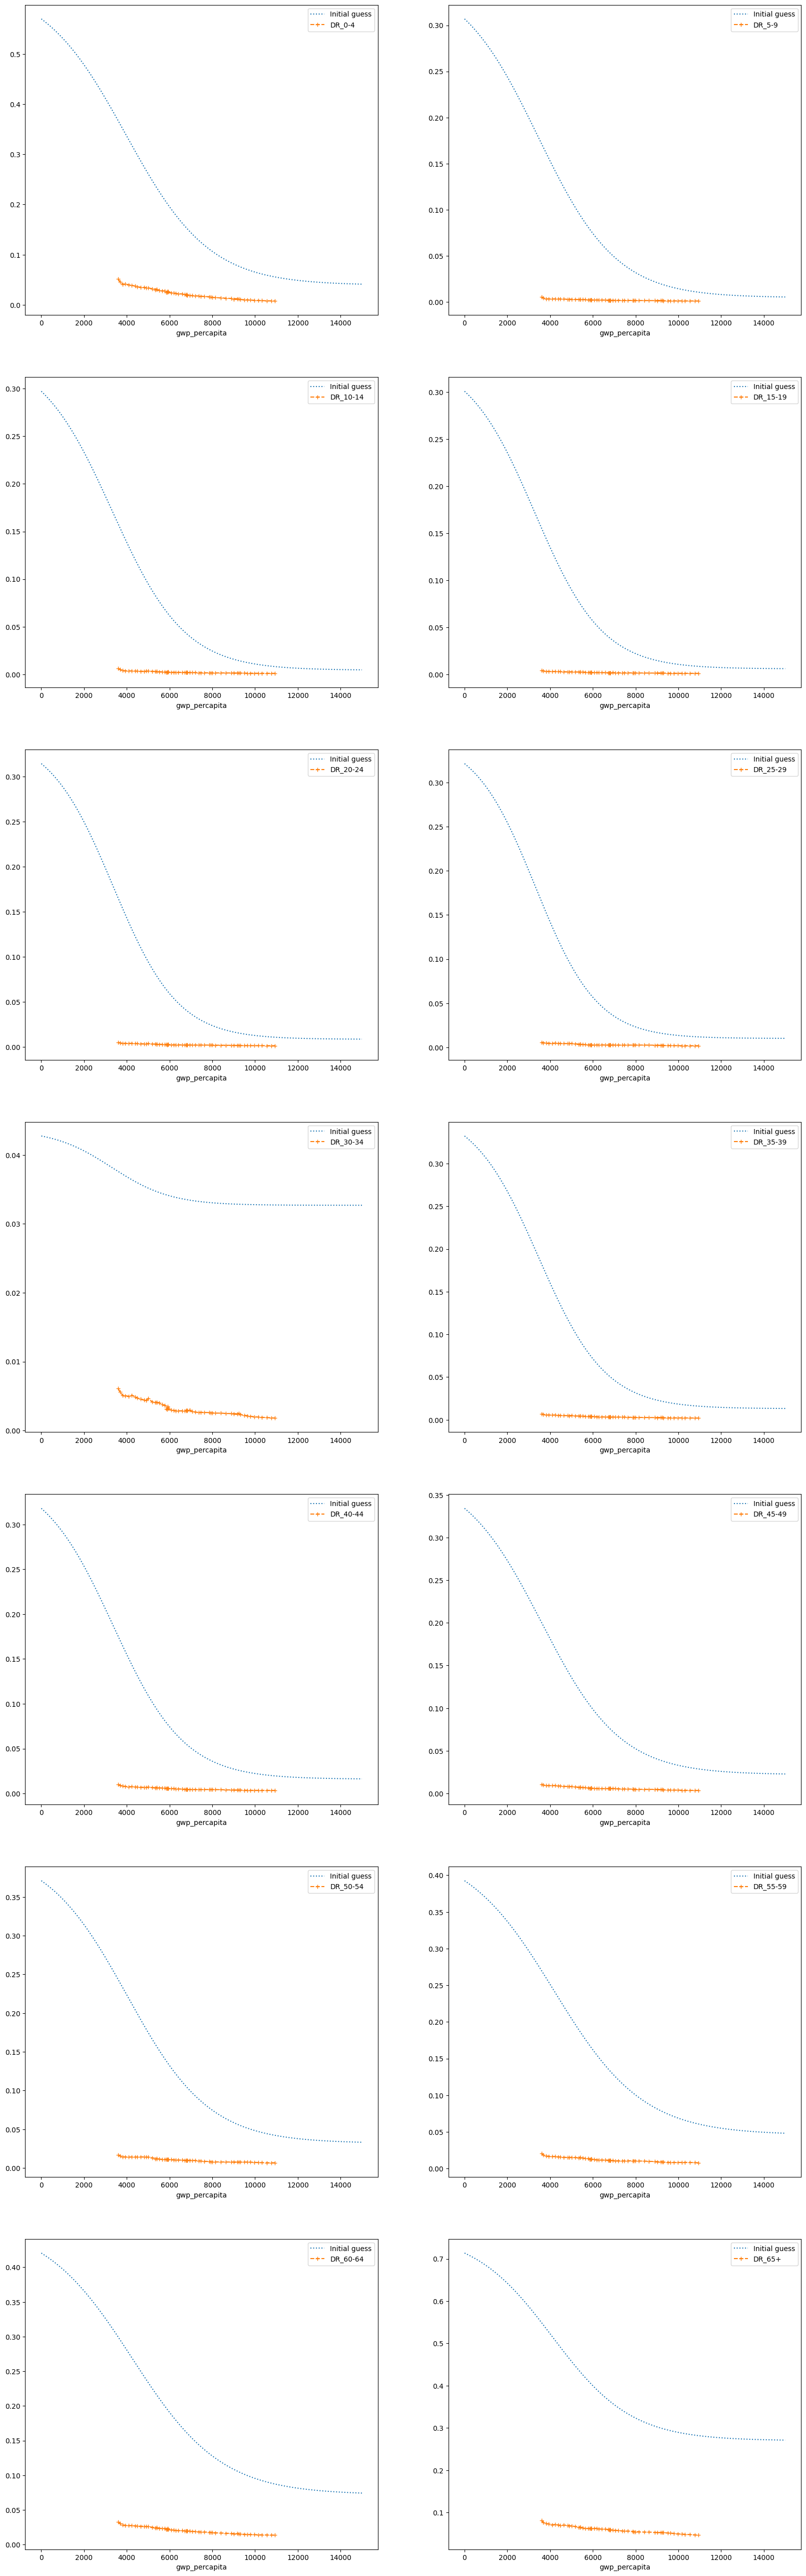

In [34]:
fig, ax = plt.subplots(7,2,figsize=(20,11*6))

gdppc_min = np.min(df.gwp_percapita.to_numpy())
gdppc_max = np.max(df.gwp_percapita.to_numpy())
#x = np.linspace(gdppc_min, gdppc_max, 10000)
x = np.linspace(0, 15000, 10000)

DR14D_fcts = {
    "DR_{0:s}".format(age_groups_dct[group_id]): {
        "init": demo_transition(x, *p0["DR_{0:s}".format(age_groups_dct[group_id])]),
    } for group_id in court_age_groups
}

BR14D_fcts = {
    "BR_{0:s}".format(age_groups_dct[group_id]): {
        "init": demo_transition(x, *p0["BR_{0:s}".format(age_groups_dct[group_id])]),
    } for group_id in fertile_court_age_groups
}

for group_lid, group_id in enumerate(court_age_groups):
    ax[group_lid//2,group_lid%2].plot(x, DR14D_fcts["DR_{0:s}".format(age_groups_dct[group_id])]["init"], linestyle=':', label="Initial guess")

    df.plot(
        x="gwp_percapita",
        y="DR_{0:s}".format(age_groups_dct[group_id]),
        ax=ax[group_lid//2,group_lid%2],
        marker='+',
        linestyle='--'
    )

    ax[group_lid//2,group_lid%2].legend()

In [44]:
for group_id in fertile_court_age_groups:
    popt, pcov = curve_fit(
        demo_transition,
        df.gwp_percapita.to_numpy(),
        df["BR_{0:s}".format(age_groups_dct[group_id])].to_numpy(),
        p0["BR_{0:s}".format(age_groups_dct[group_id])],
        method='dogbox'
    )
    BR14D_popts[age_groups_dct[group_id]] = popt
    BR14D_pcovs[age_groups_dct[group_id]] = pcov

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [27]:
for group_id in court_age_groups:
    popt, pcov = curve_fit(
        demo_transition,
        df.gwp_percapita.to_numpy(),
        df["DR_{0:s}".format(age_groups_dct[group_id])].to_numpy(),
        p0["DR_{0:s}".format(age_groups_dct[group_id])],
        method='dogbox'
    )
    DR14D_popts[age_groups_dct[group_id]] = popt
    DR14D_pcovs[age_groups_dct[group_id]] = pcov

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.